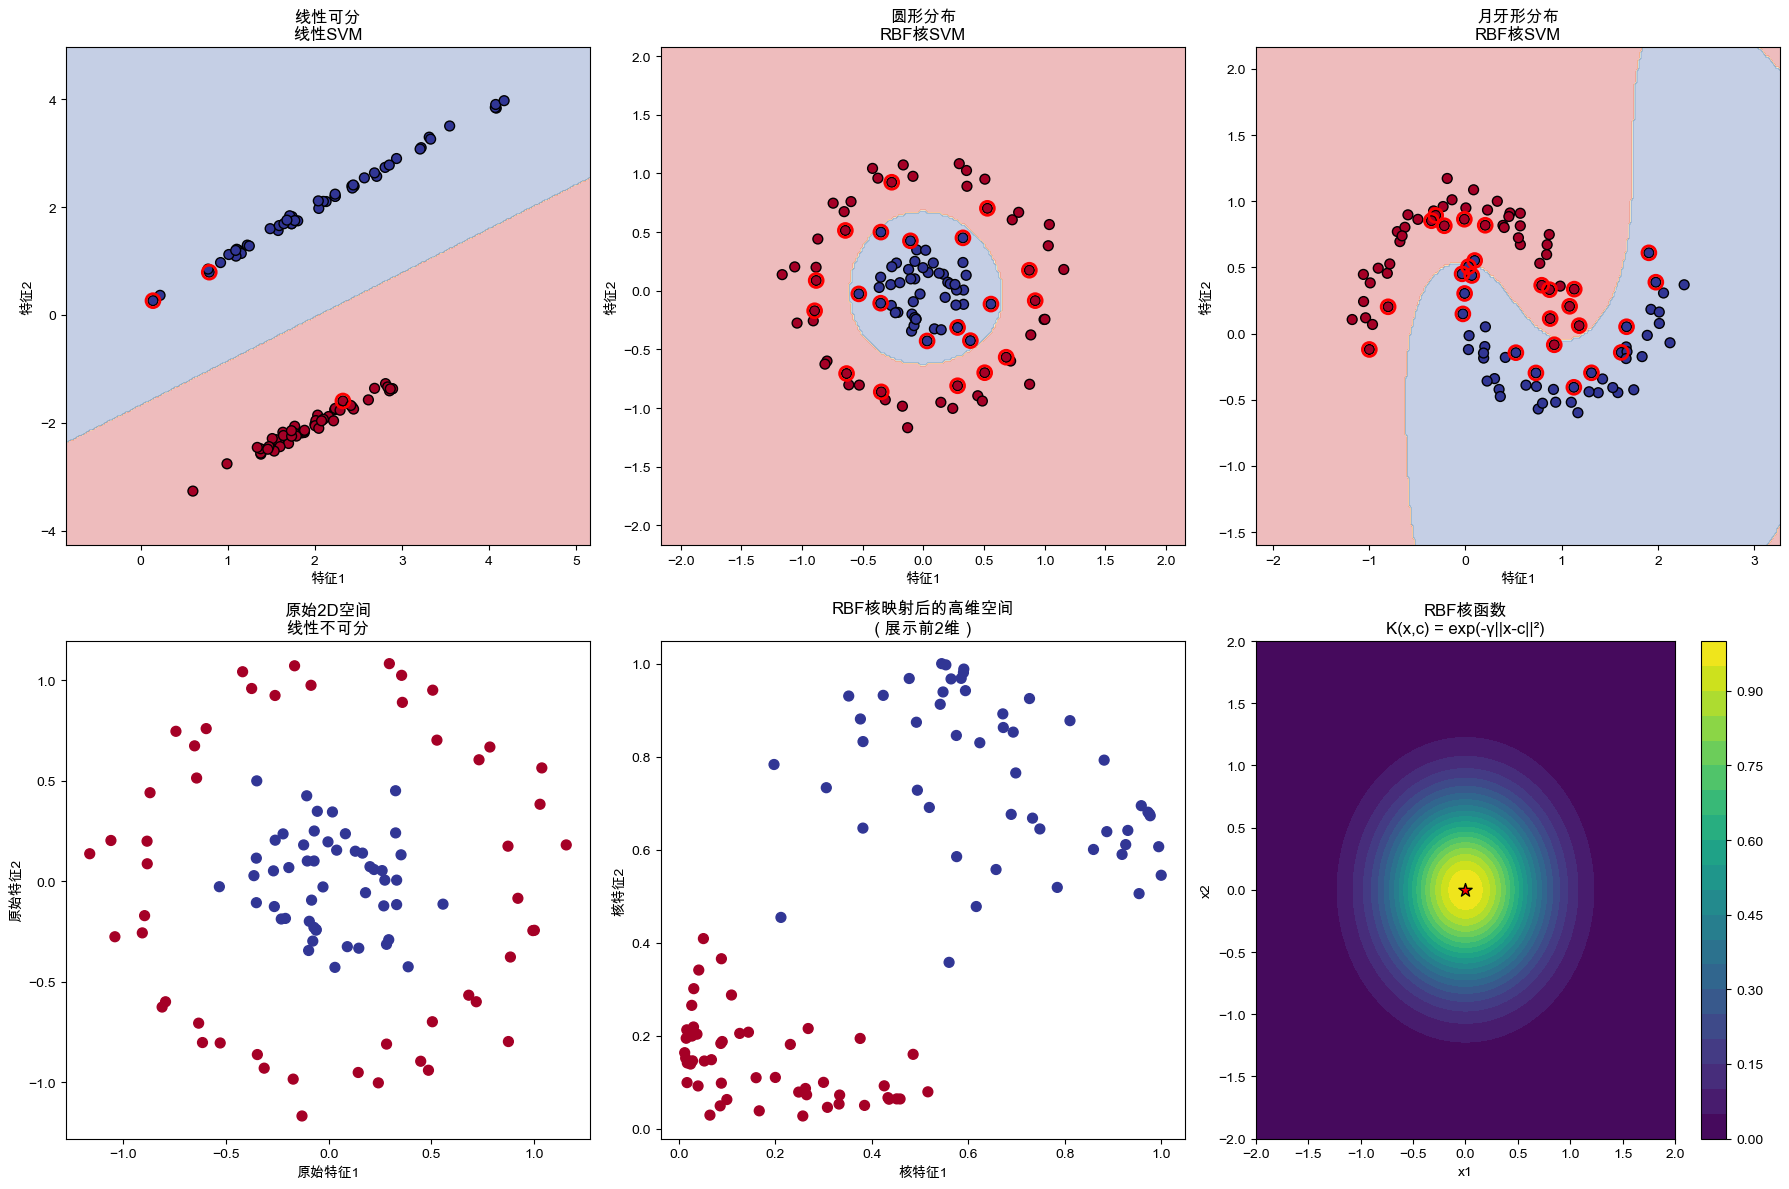

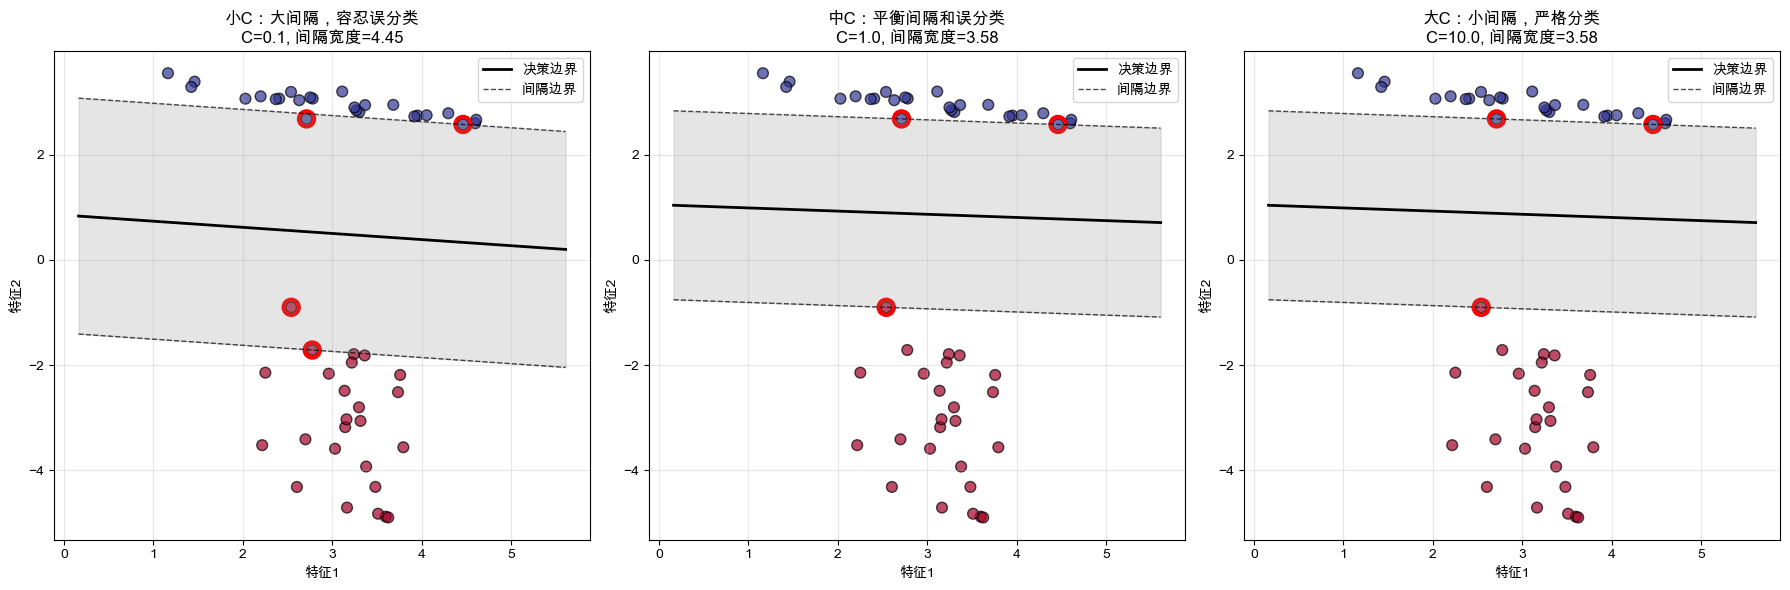

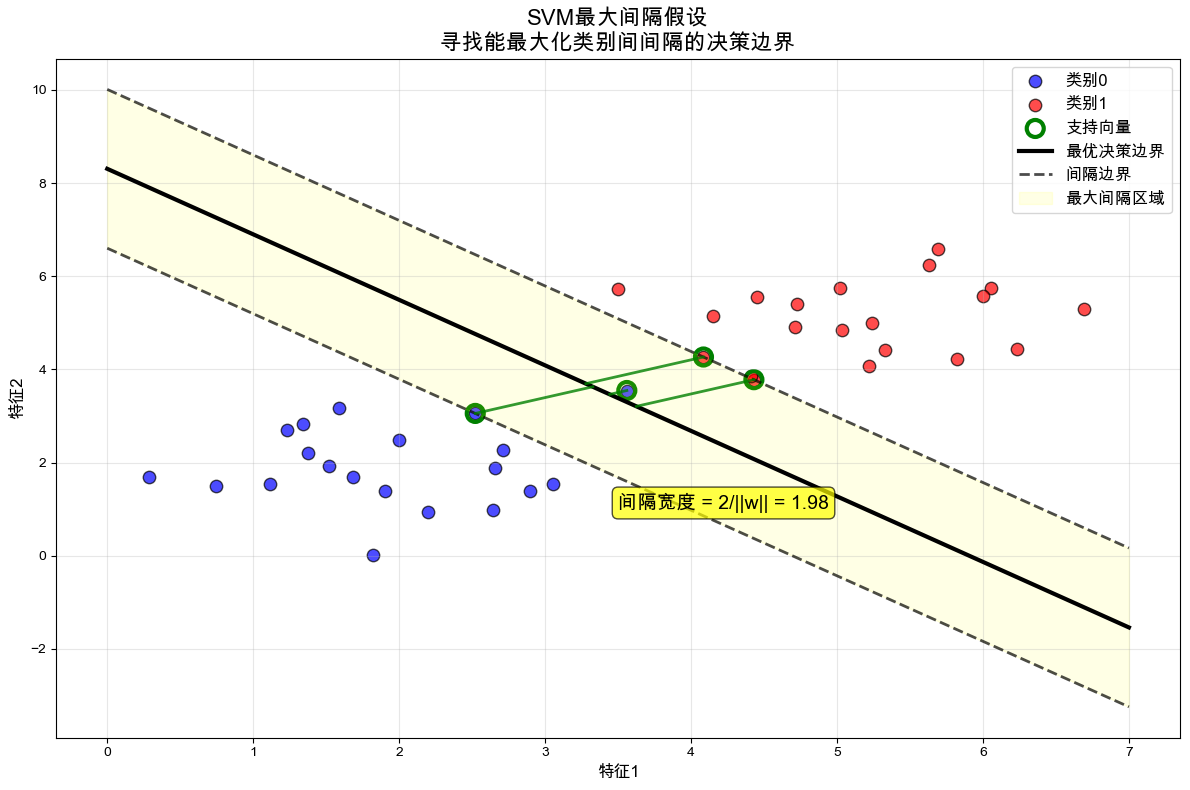

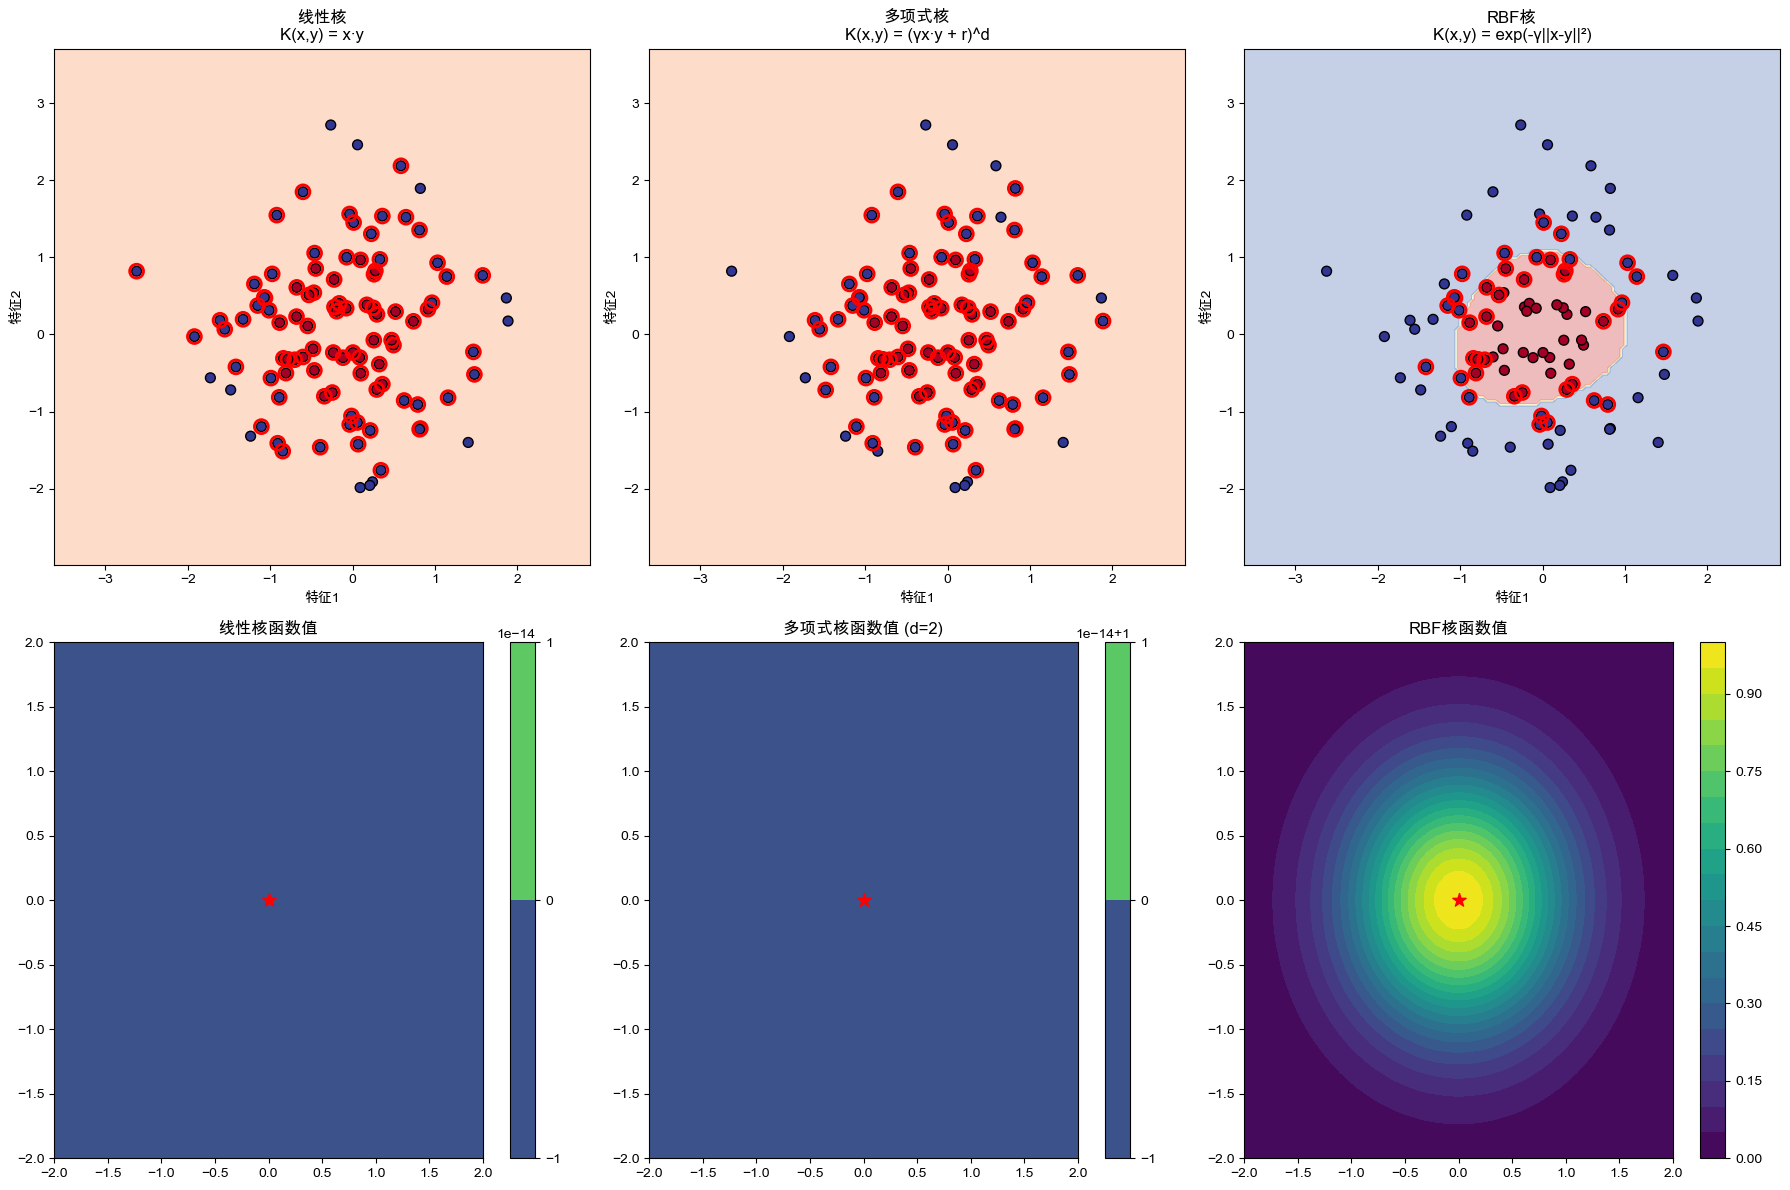

SVM的三个核心模型假设

1. 数据近似线性可分（或通过核函数在高维空间可分）
   ✓ 基本假设是类别之间存在一个'间隔最大化'的超平面
   ✓ 如果在原空间不可分，可以通过核技巧映射到高维特征空间
   ✓ 核函数使得在高维空间的线性分类变为可能

2. 分类的鲁棒性来自最大间隔假设
   ✓ 假设最优的分类超平面应该让支持向量到超平面的间隔最大
   ✓ 最大间隔原理能够提升模型的泛化能力
   ✓ C参数控制间隔和误分类之间的权衡

3. 样本之间的关系可用内积/核函数度量
   ✓ 假设数据点的相似性可通过内积来刻画
   ✓ 不同核函数适应不同的数据分布特性
   ✓ 核技巧避免了显式的高维特征映射


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification, make_circles, make_moons
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Arial Unicode MS'

# ==================== 假设1: 数据近似线性可分（或通过核函数在高维空间可分）====================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1.1 线性可分数据
np.random.seed(42)
X_linear, y_linear = make_classification(n_samples=100, n_features=2, n_redundant=0, 
                                        n_informative=2, n_clusters_per_class=1, 
                                        class_sep=2, random_state=42)

# 1.2 线性不可分但核技巧可分的数据
X_circles, y_circles = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=42)
X_moons, y_moons = make_moons(n_samples=100, noise=0.1, random_state=42)

datasets = [(X_linear, y_linear, '线性可分'), 
           (X_circles, y_circles, '圆形分布'), 
           (X_moons, y_moons, '月牙形分布')]

kernels = ['linear', 'rbf', 'rbf']
titles = ['线性SVM', 'RBF核SVM', 'RBF核SVM']

# 修复：正确的解包方式
for i, (dataset_info, kernel, title) in enumerate(zip(datasets, kernels, titles)):
    X, y, data_name = dataset_info  # 正确解包三元组
    
    # 训练SVM
    svm = SVC(kernel=kernel, C=1.0, gamma='scale')
    svm.fit(X, y)
    
    # 创建网格
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # 预测
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 绘制决策边界
    axes[0, i].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    axes[0, i].scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', s=50, edgecolors='black')
    
    # 标记支持向量
    if hasattr(svm, 'support_vectors_'):
        axes[0, i].scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], 
                          s=100, facecolors='none', edgecolors='red', linewidth=2)
    
    axes[0, i].set_title(f'{data_name}\n{title}', fontsize=12)
    axes[0, i].set_xlabel('特征1')
    axes[0, i].set_ylabel('特征2')

# 核函数效果演示
def rbf_kernel_transform(X, gamma=1.0):
    """简化的RBF核变换演示"""
    n_samples = X.shape[0]
    # 选择几个中心点
    centers = X[::20]  # 每20个点选一个作为中心
    
    # 计算到各中心点的RBF距离
    transformed = []
    for center in centers:
        distances = np.sum((X - center)**2, axis=1)
        rbf_values = np.exp(-gamma * distances)
        transformed.append(rbf_values)
    
    return np.column_stack(transformed)

# 原始圆形数据在高维空间的表示
X_circles_transformed = rbf_kernel_transform(X_circles, gamma=2.0)

# 绘制原始空间
axes[1, 0].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='RdYlBu', s=50)
axes[1, 0].set_title('原始2D空间\n线性不可分', fontsize=12)
axes[1, 0].set_xlabel('原始特征1')
axes[1, 0].set_ylabel('原始特征2')

# 绘制高维空间的前两个维度
axes[1, 1].scatter(X_circles_transformed[:, 0], X_circles_transformed[:, 1], 
                  c=y_circles, cmap='RdYlBu', s=50)
axes[1, 1].set_title('RBF核映射后的高维空间\n（展示前2维）', fontsize=12)
axes[1, 1].set_xlabel('核特征1')
axes[1, 1].set_ylabel('核特征2')

# 绘制核函数可视化
x_range = np.linspace(-2, 2, 100)
y_range = np.linspace(-2, 2, 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
center = np.array([0, 0])

# RBF核函数值
Z_rbf = np.exp(-2.0 * ((X_grid - center[0])**2 + (Y_grid - center[1])**2))

im = axes[1, 2].contourf(X_grid, Y_grid, Z_rbf, levels=20, cmap='viridis')
axes[1, 2].scatter([0], [0], c='red', s=100, marker='*', edgecolors='black')
axes[1, 2].set_title('RBF核函数\nK(x,c) = exp(-γ||x-c||²)', fontsize=12)
axes[1, 2].set_xlabel('x1')
axes[1, 2].set_ylabel('x2')
plt.colorbar(im, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# ==================== 假设2: 分类的鲁棒性来自最大间隔假设 ====================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 生成线性可分数据
np.random.seed(42)
X_margin, y_margin = make_classification(n_samples=50, n_features=2, n_redundant=0, 
                                        n_informative=2, n_clusters_per_class=1, 
                                        class_sep=3, random_state=42)

# 不同C值的SVM（软间隔）
C_values = [0.1, 1.0, 10.0]
titles = ['小C：大间隔，容忍误分类', '中C：平衡间隔和误分类', '大C：小间隔，严格分类']

for i, (C, title) in enumerate(zip(C_values, titles)):
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_margin, y_margin)
    
    # 绘制数据点
    axes[i].scatter(X_margin[:, 0], X_margin[:, 1], c=y_margin, 
                   cmap='RdYlBu', s=60, edgecolors='black', alpha=0.7)
    
    # 绘制支持向量
    axes[i].scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], 
                   s=120, facecolors='none', edgecolors='red', linewidth=3)
    
    # 绘制决策边界和间隔
    w = svm.coef_[0]
    b = svm.intercept_[0]
    
    # 决策边界
    xx = np.linspace(X_margin[:, 0].min()-1, X_margin[:, 0].max()+1, 100)
    yy = -(w[0] * xx + b) / w[1]
    axes[i].plot(xx, yy, 'k-', linewidth=2, label='决策边界')
    
    # 间隔边界
    yy_up = -(w[0] * xx + b - 1) / w[1]
    yy_down = -(w[0] * xx + b + 1) / w[1]
    axes[i].plot(xx, yy_up, 'k--', linewidth=1, alpha=0.7, label='间隔边界')
    axes[i].plot(xx, yy_down, 'k--', linewidth=1, alpha=0.7)
    
    # 填充间隔区域
    axes[i].fill_between(xx, yy_up, yy_down, alpha=0.2, color='gray')
    
    # 计算间隔宽度
    margin_width = 2 / np.linalg.norm(w)
    
    axes[i].set_title(f'{title}\nC={C}, 间隔宽度={margin_width:.2f}', fontsize=12)
    axes[i].set_xlabel('特征1')
    axes[i].set_ylabel('特征2')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== 间隔最大化的数学直觉 ====================
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# 创建简单的2D线性可分数据
np.random.seed(123)
class1 = np.random.multivariate_normal([2, 2], [[0.5, 0], [0, 0.5]], 20)
class2 = np.random.multivariate_normal([5, 5], [[0.5, 0], [0, 0.5]], 20)
X_demo = np.vstack([class1, class2])
y_demo = np.hstack([np.zeros(20), np.ones(20)])

# 训练SVM
svm_demo = SVC(kernel='linear', C=1.0)
svm_demo.fit(X_demo, y_demo)

# 绘制数据点
ax.scatter(class1[:, 0], class1[:, 1], c='blue', s=80, alpha=0.7, label='类别0', edgecolors='black')
ax.scatter(class2[:, 0], class2[:, 1], c='red', s=80, alpha=0.7, label='类别1', edgecolors='black')

# 绘制支持向量
support_vectors = svm_demo.support_vectors_
ax.scatter(support_vectors[:, 0], support_vectors[:, 1], 
          s=150, facecolors='none', edgecolors='green', linewidth=3, label='支持向量')

# 绘制决策边界和间隔
w = svm_demo.coef_[0]
b = svm_demo.intercept_[0]

xx = np.linspace(0, 7, 100)
yy = -(w[0] * xx + b) / w[1]
yy_up = -(w[0] * xx + b - 1) / w[1]
yy_down = -(w[0] * xx + b + 1) / w[1]

ax.plot(xx, yy, 'black', linewidth=3, label='最优决策边界')
ax.plot(xx, yy_up, 'black', linestyle='--', linewidth=2, alpha=0.7, label='间隔边界')
ax.plot(xx, yy_down, 'black', linestyle='--', linewidth=2, alpha=0.7)

# 填充间隔区域
ax.fill_between(xx, yy_up, yy_down, alpha=0.1, color='yellow', label='最大间隔区域')

# 添加垂直距离线（从支持向量到决策边界）
for sv in support_vectors:
    # 计算点到直线的距离
    distance = abs(w[0]*sv[0] + w[1]*sv[1] + b) / np.linalg.norm(w)
    
    # 计算垂足
    direction = w / np.linalg.norm(w)
    if w[0]*sv[0] + w[1]*sv[1] + b > 0:
        foot = sv - distance * direction
    else:
        foot = sv + distance * direction
    
    ax.plot([sv[0], foot[0]], [sv[1], foot[1]], 'green', linewidth=2, alpha=0.8)

# 计算并显示间隔宽度
margin_width = 2 / np.linalg.norm(w)
ax.text(3.5, 1, f'间隔宽度 = 2/||w|| = {margin_width:.2f}', 
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
        fontsize=14)

ax.set_title('SVM最大间隔假设\n寻找能最大化类别间间隔的决策边界', fontsize=16)
ax.set_xlabel('特征1', fontsize=12)
ax.set_ylabel('特征2', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== 假设3: 样本之间的关系可用内积/核函数度量 ====================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 生成测试数据
np.random.seed(42)
X_kernel = np.random.randn(100, 2)
y_kernel = (X_kernel[:, 0]**2 + X_kernel[:, 1]**2 > 1).astype(int)

# 不同核函数
kernels = ['linear', 'poly', 'rbf']
kernel_names = ['线性核', '多项式核', 'RBF核']
kernel_formulas = ['K(x,y) = x·y', 'K(x,y) = (γx·y + r)^d', 'K(x,y) = exp(-γ||x-y||²)']

for i, (kernel, name, formula) in enumerate(zip(kernels, kernel_names, kernel_formulas)):
    # 训练SVM
    if kernel == 'poly':
        svm_k = SVC(kernel=kernel, degree=3, C=1.0)
    else:
        svm_k = SVC(kernel=kernel, C=1.0, gamma='scale')
    
    svm_k.fit(X_kernel, y_kernel)
    
    # 创建网格
    h = 0.05
    x_min, x_max = X_kernel[:, 0].min() - 1, X_kernel[:, 0].max() + 1
    y_min, y_max = X_kernel[:, 1].min() - 1, X_kernel[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # 预测
    Z = svm_k.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 上排：决策边界
    axes[0, i].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    axes[0, i].scatter(X_kernel[:, 0], X_kernel[:, 1], c=y_kernel, 
                      cmap='RdYlBu', s=50, edgecolors='black')
    
    # 标记支持向量
    if hasattr(svm_k, 'support_vectors_'):
        axes[0, i].scatter(svm_k.support_vectors_[:, 0], svm_k.support_vectors_[:, 1], 
                          s=100, facecolors='none', edgecolors='red', linewidth=2)
    
    axes[0, i].set_title(f'{name}\n{formula}', fontsize=12)
    axes[0, i].set_xlabel('特征1')
    axes[0, i].set_ylabel('特征2')

# 下排：核函数可视化
x_range = np.linspace(-2, 2, 50)
y_range = np.linspace(-2, 2, 50)
X_vis, Y_vis = np.meshgrid(x_range, y_range)
origin = np.array([0, 0])

# 线性核
Z_linear = X_vis * origin[0] + Y_vis * origin[1]
im1 = axes[1, 0].contourf(X_vis, Y_vis, Z_linear, levels=20, cmap='viridis')
axes[1, 0].scatter([0], [0], c='red', s=100, marker='*')
axes[1, 0].set_title('线性核函数值')
plt.colorbar(im1, ax=axes[1, 0])

# 多项式核 (degree=2)
Z_poly = (1 + X_vis * origin[0] + Y_vis * origin[1])**2
im2 = axes[1, 1].contourf(X_vis, Y_vis, Z_poly, levels=20, cmap='viridis')
axes[1, 1].scatter([0], [0], c='red', s=100, marker='*')
axes[1, 1].set_title('多项式核函数值 (d=2)')
plt.colorbar(im2, ax=axes[1, 1])

# RBF核
gamma = 1.0
Z_rbf = np.exp(-gamma * (X_vis**2 + Y_vis**2))
im3 = axes[1, 2].contourf(X_vis, Y_vis, Z_rbf, levels=20, cmap='viridis')
axes[1, 2].scatter([0], [0], c='red', s=100, marker='*')
axes[1, 2].set_title('RBF核函数值')
plt.colorbar(im3, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# 打印总结
print("=" * 80)
print("SVM的三个核心模型假设")
print("=" * 80)
print("\n1. 数据近似线性可分（或通过核函数在高维空间可分）")
print("   ✓ 基本假设是类别之间存在一个'间隔最大化'的超平面")
print("   ✓ 如果在原空间不可分，可以通过核技巧映射到高维特征空间")
print("   ✓ 核函数使得在高维空间的线性分类变为可能")

print("\n2. 分类的鲁棒性来自最大间隔假设")
print("   ✓ 假设最优的分类超平面应该让支持向量到超平面的间隔最大")
print("   ✓ 最大间隔原理能够提升模型的泛化能力")
print("   ✓ C参数控制间隔和误分类之间的权衡")

print("\n3. 样本之间的关系可用内积/核函数度量")
print("   ✓ 假设数据点的相似性可通过内积来刻画")
print("   ✓ 不同核函数适应不同的数据分布特性")
print("   ✓ 核技巧避免了显式的高维特征映射")

In [37]:
import numpy as np

class MySVM:
    def __init__(self, C=1.0, tol=1e-3, max_iter=1000, kernel='linear', 
                 method='SMO', sigma=1.0, use_sgd=False, eta=0.001):
        """
        C: 惩罚系数
        tol: KKT容差
        max_iter: 最大迭代次数
        kernel: 'linear' 或 'rbf'
        method: 'SMO' 或 'GD'
        sigma: RBF核宽度
        use_sgd: 仅在GD方法下有效，是否使用随机梯度下降
        eta: 学习率（GD方法）
        """
        self.C = C
        self.tol = tol
        self.max_iter = max_iter
        self.kernel_type = kernel
        self.method = method
        self.sigma = sigma
        self.use_sgd = use_sgd
        self.eta = eta

    def _kernel(self, x1, x2):
        if self.kernel_type == 'linear':
            return np.dot(x1, x2)
        elif self.kernel_type == 'rbf':
            return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * self.sigma ** 2))
        else:
            raise ValueError("Unknown kernel type")

    def _compute_kernel_matrix(self, X):
        m = X.shape[0]
        K = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                K[i, j] = self._kernel(X[i], X[j])
        return K

    def _E(self, i):
        return self.predict_one(self.X[i]) - self.y[i]

    def _select_j(self, i, m, Ei):
        max_diff = -1
        j = -1
        Ej = 0
        for k in range(m):
            if k == i:
                continue
            Ek = self._E(k)
            diff = abs(Ei - Ek)
            if diff > max_diff:
                max_diff = diff
                j = k
                Ej = Ek
        if j == -1:
            j = np.random.randint(0, m)
            while j == i:
                j = np.random.randint(0, m)
            Ej = self._E(j)
        return j, Ej

    def fit(self, X, y):
        m = X.shape[0]
        y = y.astype(float)
        self.X, self.y = X, y

        if self.method == 'SMO':
            self.alpha = np.zeros(m)
            self.b = 0
            self.K = self._compute_kernel_matrix(X)
            iters = 0
            while iters < self.max_iter:
                alpha_changed = 0
                for i in range(m):
                    Ei = self._E(i)
                    if (y[i]*Ei < -self.tol and self.alpha[i] < self.C) or \
                        (y[i]*Ei > self.tol and self.alpha[i] > 0):
                        j, Ej = self._select_j(i, m, Ei)
                        alpha_i_old, alpha_j_old = self.alpha[i], self.alpha[j]

                        # 计算边界
                        if y[i] != y[j]:
                            L = max(0, self.alpha[j] - self.alpha[i])
                            H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                        else:
                            L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                            H = min(self.C, self.alpha[i] + self.alpha[j])
                        if L == H:
                            continue

                        # eta
                        eta = self.K[i,i] + self.K[j,j] - 2*self.K[i,j]
                        if eta <= 0:
                            continue

                        # 更新 alpha_j
                        self.alpha[j] += y[j]*(Ei - Ej)/eta
                        self.alpha[j] = np.clip(self.alpha[j], L, H)
                        if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                            continue
                        # 更新 alpha_i
                        self.alpha[i] += y[i]*y[j]*(alpha_j_old - self.alpha[j])

                        # 更新偏置 b
                        b1 = self.b - Ei - y[i]*(self.alpha[i]-alpha_i_old)*self.K[i,i] - \
                        y[j]*(self.alpha[j]-alpha_j_old)*self.K[i,j]
                        b2 = self.b - Ej - y[i]*(self.alpha[i]-alpha_i_old)*self.K[i,j] - \
                        y[j]*(self.alpha[j]-alpha_j_old)*self.K[j,j]
                        if 0 < self.alpha[i] < self.C:
                            self.b = b1
                        elif 0 < self.alpha[j] < self.C:
                            self.b = b2
                        else:
                            self.b = (b1 + b2)/2

                        alpha_changed += 1
                if alpha_changed == 0:
                    iters += 1
                else:
                    iters = 0

        elif self.method == 'GD':
            self.w = np.zeros(X.shape[1])
            self.b = 0
            for iteration in range(self.max_iter):
                if self.use_sgd:
                    indices = np.random.permutation(m)
                else:
                    indices = np.arange(m)

                dw = np.zeros_like(self.w)
                db = 0
                for i in indices:
                    condition = y[i]*(np.dot(self.w, X[i]) + self.b)
                    if condition < 1:
                        dw -= self.C * y[i] * X[i]
                        db -= self.C * y[i]
                dw += self.w
                self.w -= self.eta * dw
                self.b -= self.eta * db
        else:
            raise ValueError("Unsupported method")
        return self

    def predict_one(self, x):
        if self.method == 'GD':
            return np.dot(self.w, x) + self.b
        else:
            result = 0
            for i in range(len(self.alpha)):
                if self.alpha[i] > 1e-6:
                    result += self.alpha[i]*self.y[i]*self._kernel(self.X[i], x)
            return result + self.b

    def predict(self, X):
        return np.sign(np.array([self.predict_one(x) for x in X]))

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


SMO Accuracy: 0.8333333333333334
BGD Accuracy: 0.8666666666666667
SGD Accuracy: 0.8666666666666667


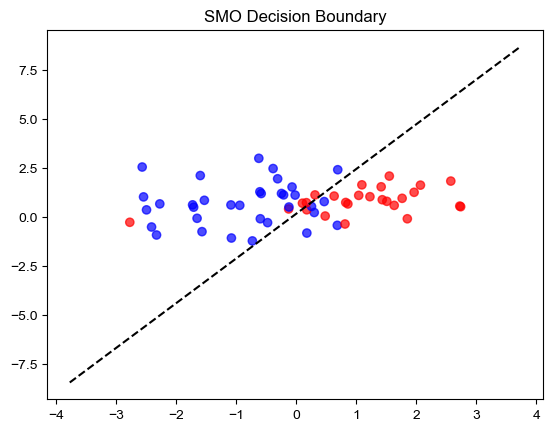

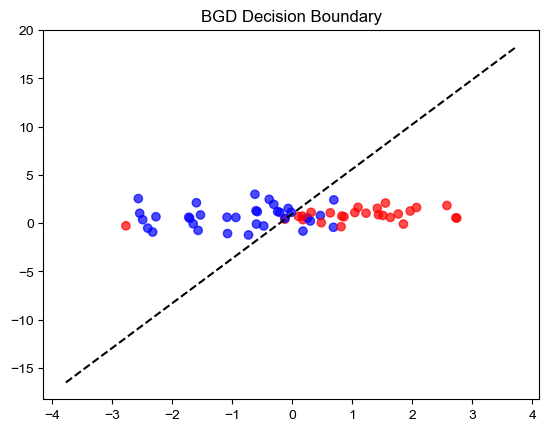

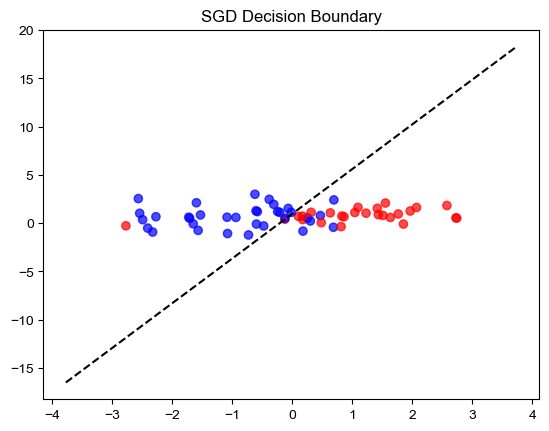

In [38]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 生成简单的二分类数据
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, flip_y=0, random_state=42)
y = np.where(y == 0, -1, 1)  # SVM 要求标签 -1/+1

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 1️⃣ SMO
smo_model = MySVM(method='SMO', C=1.0, tol=1e-3, max_iter=1000, kernel='linear')
smo_model.fit(X_train, y_train)
print("SMO Accuracy:", smo_model.score(X_test, y_test))

# 2️⃣ BGD
bgd_model = MySVM(method='GD', use_sgd=False, eta=0.001, max_iter=1000, C=1.0)
bgd_model.fit(X_train, y_train)
print("BGD Accuracy:", bgd_model.score(X_test, y_test))

# 3️⃣ SGD
sgd_model = MySVM(method='GD', use_sgd=True, eta=0.001, max_iter=1000, C=1.0)
sgd_model.fit(X_train, y_train)
print("SGD Accuracy:", sgd_model.score(X_test, y_test))

# 可视化结果（可选）
import matplotlib.pyplot as plt

def plot_svm(model, X, y, title):
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.7)
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx = np.linspace(x_min, x_max, 100)
    if model.method == 'GD':
        w, b = model.w, model.b
        yy = -(w[0]*xx + b)/w[1]
    else:
        # SMO 线性核
        w = np.sum((model.alpha*model.y)[:,None] * X_train, axis=0)
        b = model.b
        yy = -(w[0]*xx + b)/w[1]
    plt.plot(xx, yy, 'k--')
    plt.title(title)
    plt.show()

plot_svm(smo_model, X_test, y_test, "SMO Decision Boundary")
plot_svm(bgd_model, X_test, y_test, "BGD Decision Boundary")
plot_svm(sgd_model, X_test, y_test, "SGD Decision Boundary")


In [ ]:
# Pytorch实现SVM

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class MySVM_PyTorch:
    def __init__(self, C=1.0, tol=1e-3, max_iter=1000, kernel='linear', 
                 method='SMO', sigma=1.0, use_sgd=False, eta=0.001):
        self.C = C
        self.tol = tol
        self.max_iter = max_iter
        self.kernel_type = kernel
        self.method = method
        self.sigma = sigma
        self.use_sgd = use_sgd
        self.eta = eta

    def _kernel(self, X1, X2):
        if self.kernel_type == 'linear':
            return X1 @ X2.T
        elif self.kernel_type == 'rbf':
            X1_sq = (X1 ** 2).sum(dim=1).unsqueeze(1)
            X2_sq = (X2 ** 2).sum(dim=1).unsqueeze(0)
            K = X1_sq + X2_sq - 2 * (X1 @ X2.T)
            return torch.exp(-K / (2 * self.sigma ** 2))
        else:
            raise ValueError("Unknown kernel type")
        
    def _select_j(self, i, m, Ei):
        max_diff = -1
        j = -1
        Ej = 0
        for k in range(m):
            if k == i:
                continue
            Ek = self._E(k)
            diff = abs(Ei - Ek)
            if diff > max_diff:
                max_diff = diff
                j = k
                Ej = Ek
        if j == -1:
            j = torch.randint(0, m, (1,)).item()
            while j == i:
                j = torch.randint(0, m, (1,)).item()
            Ej = self._E(j)
        return j, Ej

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        self.X = X
        self.y = y
        n_samples, n_features = X.shape

        if self.method == 'GD':
            # 线性SVM权重和偏置
            self.w = nn.Parameter(torch.zeros(n_features))
            self.b = nn.Parameter(torch.zeros(1))
            optimizer = optim.SGD([self.w, self.b], lr=self.eta)
            
            for it in range(self.max_iter):
                if self.use_sgd:
                    indices = torch.randperm(n_samples)
                else:
                    indices = torch.arange(n_samples)
                
                for i in indices:
                    optimizer.zero_grad()
                    xi, yi = X[i], y[i]
                    # 计算整体损失函数（正则化项+铰链损失项）
                    margin = None # TODO，计算margin，提示：yi * (xi @ w + b)
                    loss = None # TODO: 计算损失(正则化项目)，提示：1/2 * ||w||^2 
                    if margin < 1:
                        loss += None # 计算损失(铰链损失项)，提示：C * max(0, 1 - margin)
                    loss.backward()
                    optimizer.step()
        
        elif self.method == 'SMO':
            # alpha参数初始化
            self.alpha = torch.zeros(n_samples, dtype=torch.float32)
            self.b = torch.tensor(0.0, dtype=torch.float32)
            K = self._kernel(X, X)
            
            iters = 0
            while iters < self.max_iter:
                alpha_changed = 0
                for i in range(n_samples):
                    Ei = torch.sum(self.alpha * y * K[:, i]) + self.b - y[i]
                    if (y[i]*Ei < -self.tol and self.alpha[i] < self.C) or \
                       (y[i]*Ei > self.tol and self.alpha[i] > 0):
                        # 选择第二个变量j
                        j, Ej = self._select_j(i, n_samples, Ei)
                        
                        alpha_i_old = self.alpha[i].clone()
                        alpha_j_old = self.alpha[j].clone()
                        
                        # 计算边界L, H（分类两种情况）
                        if y[i] != y[j]:
                            L = None # TODO: 计算L
                            H = None # TODO: 计算H
                        else:
                            L = None # TODO: 计算L
                            H = None #TODO: 计算H
                        if L == H:
                            continue
                        
                        eta = None # TODO: 计算eta，提示：Kii + Kjj - 2 * Kij
                        if eta <= 0:
                            continue
                        
                        # 更新alpha[j]并限制在[L, H]之间 
                        self.alpha[j] += None  # TODO: 更新alpha[j]，提示：yj * (Ei - Ej) / Kii+Kjj - 2*Kij(之前计算好的eta)
                        self.alpha[j] = None # TODO: 限制alpha[j]在[L, H]之间，提示：torch.clamp()方法
                        if torch.abs(self.alpha[j] - alpha_j_old) < 1e-5:
                            continue
                        # 更新alpha[i]
                        self.alpha[i] += None # TODO: 更新alpha[i]，提示：yi * yj * (alpha_j_old - alpha_j_new)
                        
                        # 更新偏置b 
                        b1 = None # TODO: 计算b1，提示：self.b - Ei - y[i]*(self.alpha[i]-alpha_i_old)*K[i,i] - y[j]*(self.alpha[j]-alpha_j_old)*K[i,j]
                        b2 = None # TODO: 计算b2，提示：self.b - Ej - y[i]*(self.alpha[i]-alpha_i_old)*K[i,j] - y[j]*(self.alpha[j]-alpha_j_old)*K[j,j]
                        if 0 < self.alpha[i] < self.C:
                            pass # TODO: 更新偏置b，提示：b1赋给对象的b属性
                        elif 0 < self.alpha[j] < self.C:
                            pass # TODO: 更新偏置b，提示：b2赋给对象的b属性
                        else:
                            pass # TODO : 更新偏置b，提示：平均(b1, b2)赋给对象的b属性
                        
                        alpha_changed += 1
                if alpha_changed == 0:
                    iters += 1
                else:
                    iters = 0
        else:
            raise ValueError("Unsupported method")
        return self

    def predict_one(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        if self.method == 'GD':
            return (x @ self.w + self.b).item()
        else:
            result = torch.sum(self.alpha * self.y * self._kernel(self.X, x.unsqueeze(0)).squeeze()) + self.b
            return result.item()

    def predict(self, X):
        return np.sign(np.array([self.predict_one(x) for x in X]))

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


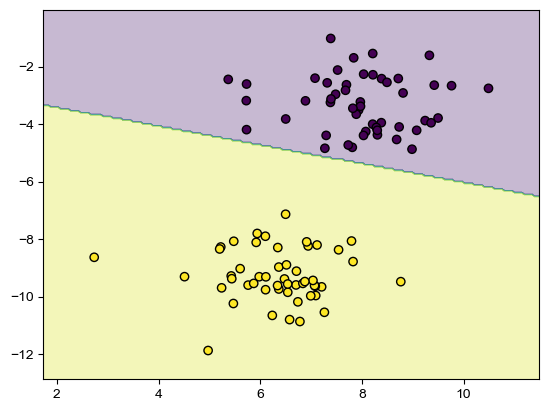

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[50  0]
 [ 0 50]]


In [16]:
# toy 数据集
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

X, y = make_blobs(n_samples=100, centers=2, random_state=6)
y = np.where(y == 0, -1, 1)  # 转换成 -1 / 1

# 训练
clf = MySVM(C=1.0, kernel='linear')
clf.fit(X, y)

# 可视化决策边界
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k')
plt.show()

# 训练预测
y_pred = clf.predict(X)

# 计算指标
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)


In [ ]:
# 

## 算法实战：情感二分类
Kaggle仓库：https://www.kaggle.com/datasets/thedevastator/imdb-large-movie-review-dataset-binary-sentiment?select=train.csv

In [23]:
import pandas as pd

# 读取数据  
data = pd.read_csv('train.csv')
texts = data['text'].values
labels = data['label'].values

# 查看数据
print("数据样本：", texts[:5])
print("标签样本：", labels[:5])
print("数据集大小：", len(texts))


数据样本： ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far betw

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# 文本向量化
# SVM 不能直接处理文本，所以需要把文本转成数值向量，这里用 TF-IDF：
# max_features=5000：保留最重要的 5000 个词；stop_words='english'：去掉英文停用词
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english') 
X = vectorizer.fit_transform(texts)
y = labels

print("文本向量化：", X[:5, :5].toarray()) 
print("文本向量化后形状：", X.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


文本向量化： [[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.09559651 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
文本向量化后形状： (25000, 5000)


In [30]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', C=1.0)  # 线性核效果通常很好
svm_model.fit(X_train, y_train)

# 预测
y_pred = svm_model.predict(X_test)

print("SVM预测准确率:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

SVM预测准确率: 0.881
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2515
           1       0.87      0.89      0.88      2485

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [ ]:
# 读取外部测试集并进行预测评估  
test_data = pd.read_csv("test.csv")
X_test_texts = test_data['text'].values
X_test = vectorizer.transform(X_test_texts)
y_test_true = test_data['label'].values

y_test_pred = svm_model.predict(X_test)

print("外部测试集合的SVM预测准确率:", accuracy_score(y_test_true, y_test_pred))
print(classification_report(y_test_true, y_test_pred))

外部测试集合的SVM预测准确率: 0.86852
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

